In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

Nous pouvions résoudre ce probleme en effectuant de la segmentation d'image 

    - Image segmentation by Kmeans
    - Image segmentation by edge detection
    - Image segmentation by color masking


# Segmentation by Kmeans

source : https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/

In [7]:
land = cv2.imread("land.jpg")
cass = cv2.imread("cassiope.png")
ball = cv2.imread("ball.jpg")

(562, 836, 3)


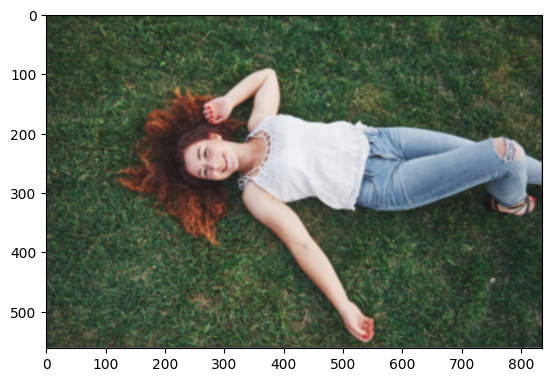

In [28]:

img_rgb = cv2.cvtColor(cass, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
print(cass.shape)

## Preprocessing

On retaille nptre image de  (x, x, 3) à (X*X, 3) puis on le convertit en flotante

In [30]:
to2dim_img = img_rgb.reshape((-1, 3))
to2dim_img = np.float32(to2dim_img)

## Declaration des hyperparametre de K-moyenne

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) #  tuple of type, max_iteration and epsilon of the criteria
K = 2  # initial K differente cluster
attempts=10 # nbre of attempts

## Application d l'algorithme K-mean

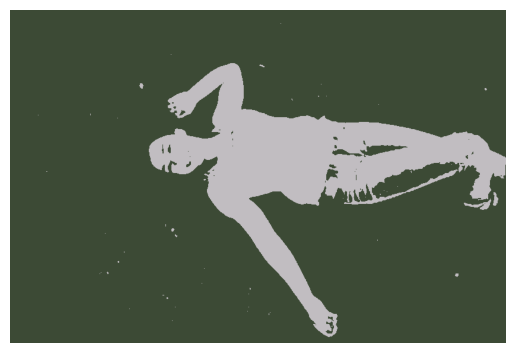

In [31]:
ret, labels, center = cv2.kmeans(to2dim_img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)
res = center[labels.flatten()]
result_img = res.reshape((img_rgb.shape))

plt.axis('off')
plt.imshow(result_img)

La segmentation Kmeans on ne parvient pas à extraire  les cheveau de la femme donc il s'avére inefficace

# Segmentation par detection de contours

source : https://learnopencv.com/contour-detection-using-opencv-python-c/

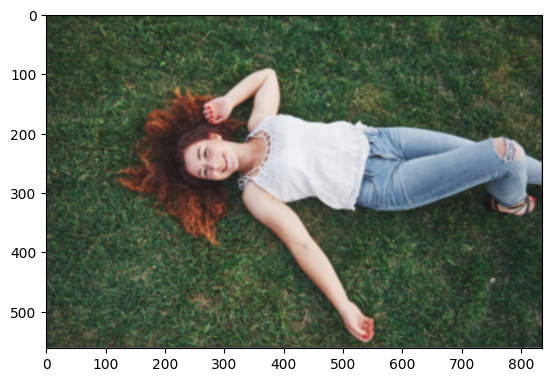

In [12]:

img_rgb = cv2.cvtColor(cass, cv2.COLOR_BGR2RGB)
#img_brg = cv2.resize(img_brg,(256,256))
plt.imshow(img_rgb)  

## Application du seuillage 

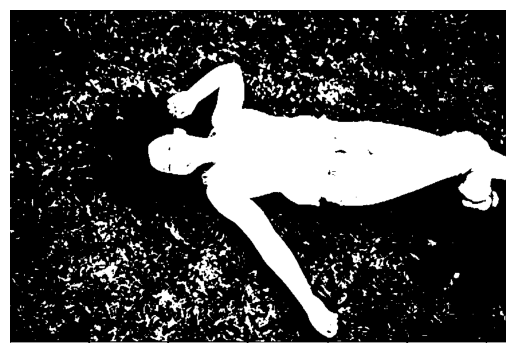

In [13]:
gray = cv2.cvtColor(cass, cv2.COLOR_RGB2GRAY)
_,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY)

plt.axis('off')
plt.imshow(thresh, cmap="gray")

## Detection des contours 

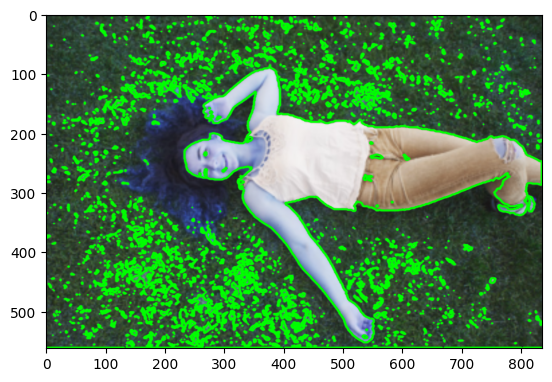

In [14]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
# draw contours on the original image
image_copy = cass.copy()
cass_countour= cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.imshow(cass_countour)
     

Le cheveux sont toujours pas pris en compte

Pour les micro objet detecter au passage on peut appliquer un nettoyage par morphology : par example un ouverture pour eliminer les eliminer

Image Segementation by Color Masking

source : https://www.kaggle.com/code/sanikamal/image-segmentation-using-color-spaces

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [34]:

def process_image (img, background_img) :
    

    # on passe de rgb a hsv pour avoir un plus grand variance de coleur et ainsi
    # avoir une meilleur separabilité des couleurs (voir source)
    hsv_img  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.axis("off")
    plt.title("Image Originale")
    plt.show()
    lower_bound = np.array([17, 17, 17]) #lower threshold
    upper_bound = np.array([80, 255, 255]) # upper threshold
    # le choix des seuils haut et bas determine la  qualite ou la precision 
    # de la segmlentation


    # creation du masque à partir des seuil haut et bas
    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)

    # le masque appliqué est appliqué pour extraire l'objet segmenté
    # de la telle le corps de la fille garde ses pixels et le fond devient noir
    object_without_background = cv2.bitwise_and(rgb_img, rgb_img, mask=~mask)
    plt.imshow(object_without_background)
    plt.axis("off")
    plt.title("Image sans fond")
    plt.show()


    # on retaille l'image du fond pour la meme taille que le l'image à coller
    background_resized = cv2.resize(background_img, (img.shape[1], img.shape[0]))



    # on apllique le masque a l'image de fond de telle sorte que le forme du corp de la fille 
    # apparait en noir (comme un trou) et le reste du fond garde sa texture
    background_with_hole = cv2.bitwise_and(background_resized, background_resized, mask=mask)



    # pour terminer on superpose les 2 images obtenue
    result_image = background_with_hole + object_without_background
    plt.imshow(result_image)
    plt.axis("off")
    plt.title("Image resultante")
    plt.show()

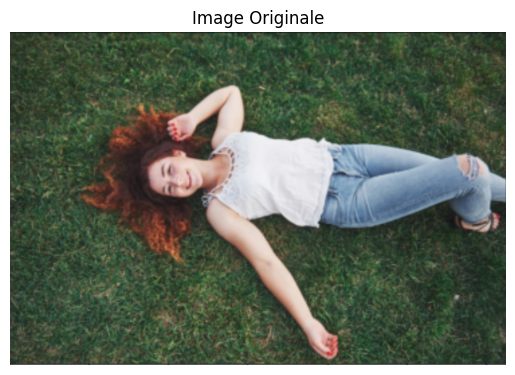

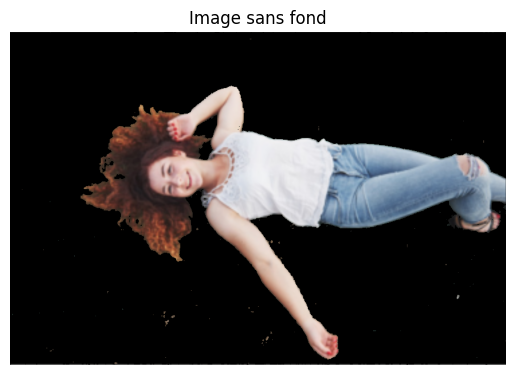

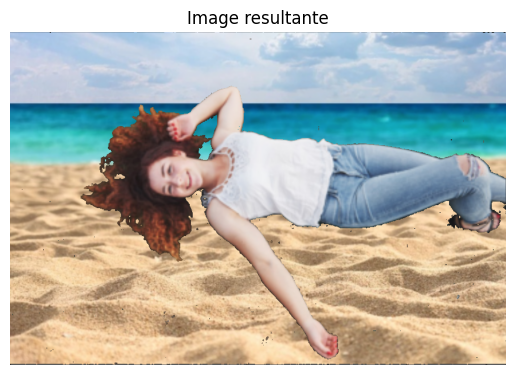

In [35]:
dubai = cv2.imread("dubai.png")

process_image (cass, dubai)



On peut remarger quelques artefacts au niveau de l'image sans fond.

Cela est a notre masque obtenue par double seuillage.

## Segmentation avec  nettoyage du masque

### Réecrivons notre fonction en appliquant une ouverture au niveau de notre masque pour eliminer les artefacts

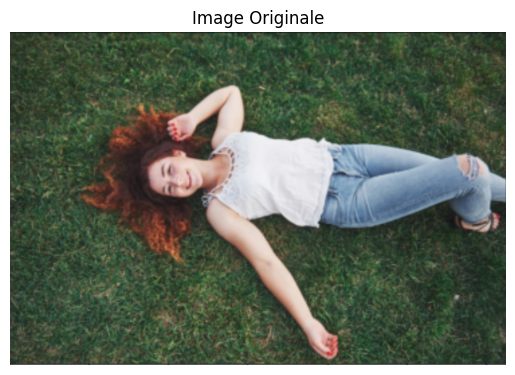

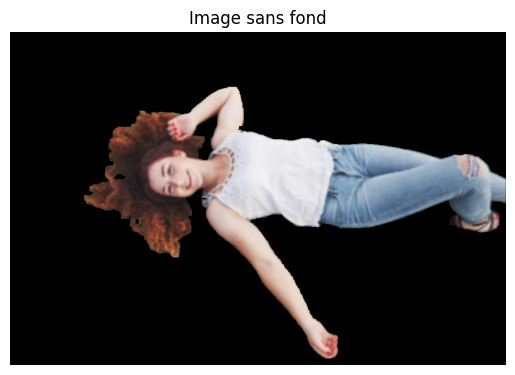

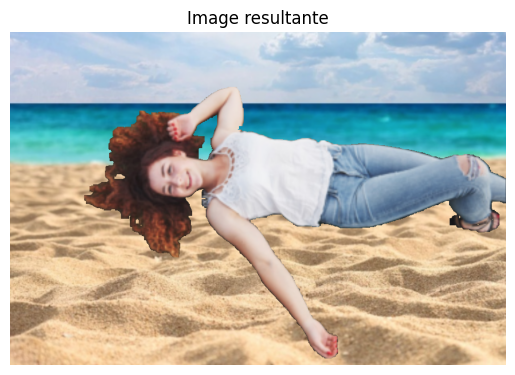

In [38]:

def process_image (img, background_img) :
    

    # on passe de rgb a hsv pour avoir un plus grand variance de coleur et ainsi
    # avoir une meilleur separabilité des couleurs (voir source)
    hsv_img  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.axis("off")
    plt.title("Image Originale")
    plt.show()
    lower_bound = np.array([17, 17, 17]) #lower threshold
    upper_bound = np.array([80, 255, 255]) # upper threshold
    # le choix des seuils haut et bas determine la  qualite ou la precision 
    # de la segmlentation


    # creation du masque à partir des seuil haut et bas
    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    # nettoyage du masque par ouveture 
    kernel = np.ones((9, 9),np.uint8)
    opened_mask = ~cv2.morphologyEx(~mask, cv2.MORPH_OPEN, kernel)

    # le masque appliqué est appliqué pour extraire l'objet segmenté
    # de la telle le corps de la fille garde ses pixels et le fond devient noir
    object_without_background = cv2.bitwise_and(rgb_img, rgb_img, mask=~opened_mask)
    plt.imshow(object_without_background)
    plt.axis("off")
    plt.title("Image sans fond")
    plt.show()


    # on retaille l'image du fond pour la meme taille que le l'image à coller
    background_resized = cv2.resize(background_img, (img.shape[1], img.shape[0]))



    # on apllique le masque a l'image de fond de telle sorte que le forme du corp de la fille 
    # apparait en noir (comme un trou) et le reste du fond garde sa texture
    background_with_hole = cv2.bitwise_and(background_resized, background_resized, mask=opened_mask)



    # pour terminer on superpose les 2 images obtenue
    result_image = background_with_hole + object_without_background
    plt.imshow(result_image)
    plt.axis("off")
    plt.title("Image resultante")
    plt.show()


process_image(cass, dubai)

## Alors là que dire de plus 😁😁😁😁